In [1]:
import numpy as np
import pandas as pd
#import numpy and pandas libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt

#import necessary libraries in Pytorch and matplotlib

In [3]:
dataset_folder = "../../dataset/"
oil_df = pd.read_csv(dataset_folder + 'oil.csv')
coin_df = pd.read_csv(dataset_folder + 'coin.csv')
microsoft_df = pd.read_csv(dataset_folder + 'microsoft.csv')
sp500_df = pd.read_csv(dataset_folder + 'sp500.csv')
artificial1_df = pd.read_csv(dataset_folder + 'Artificial_trend.csv')
artificial2_df = pd.read_csv(dataset_folder + 'Artificial_trend1.csv')

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#we import MinMaxScaler function from sklearn to scale our dataset and also make a instance of that

In [5]:
def format_train_test (batch_size, data, percent, num_predicts, column_i):
    """
    Here is the function to make train set, test set, and label for each of them from the dataframe.We first want to see how many
    We want to find the percent of data used for train set. Then, we find length of train data so that it could divisible by batch 
    size. Then we scale the dataset and make train set and label for each by iterating through the dataset until and make them lag
    by number of predict steps we want until we have desired amount of data for train process. Then, we find the length for test
    set and we repeat the same process as forming train set and its label.

    Parameters
    ----------
    batch_size : int
        Num of batch size split
    data : DataFrame
        The dataframe that is needed
    percent : double
        Percentage split between train and test. e.g. 0.2 means 80% train and 20% test
    num_predicts : int
        Nume of predictions
    column_i : 
        The column in the data that you want to make train test set from
    """

    length_train = int(data.shape[0]*(1-percent))
    a1 = length_train//batch_size
    length_train = batch_size*a1
    train_data = data.iloc[:,column_i:column_i+1].values
    train_data = scaler.fit_transform(train_data)
    train_set = []
    train_label = []
    for i in range(length_train):
        train_set.append(train_data[i:i + num_predicts])
        train_label.append(train_data[i + num_predicts:i + 2*num_predicts])
    
    length_test = int(data.shape[0] - length_train - 4*num_predicts)
    a2 = length_test//batch_size
    length_test = int(batch_size*a2) 
    test = data.iloc[:,column_i:column_i+1].values
    test = scaler.fit_transform(test)
    test_data = test[length_train + 2*num_predicts:length_train + length_test + 4*num_predicts]
    test_set = []
    test_label = []
    for j in range(length_test):
        test_set.append(test_data[j:j + num_predicts])
        test_label.append(test_data[j + num_predicts:j + 2*num_predicts])
        
    
    train_set = np.reshape(np.array(train_set),(np.array(train_set).shape[0], np.array(train_set).shape[1], 1))
    train_label = np.reshape(np.array(train_label),(np.array(train_label).shape[0], np.array(train_label).shape[1]))
    test_set = np.reshape(np.array(test_set),(np.array(test_set).shape[0], np.array(test_set).shape[1], 1))
    test_label = np.reshape(np.array(test_label),(np.array(test_label).shape[0], np.array(test_label).shape[1]))
    
    return train_set, train_label, test_set, test_label, length_test


In [6]:
coin_df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [7]:
class LSTM_model(nn.Module):
    def __init__(self, out_size, in_size, hidden_size1, hidden_size2,batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.in_size = in_size
        self.out_size = out_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.lstm1 = nn.LSTM(input_size=self.in_size,hidden_size=self.hidden_size1,num_layers=2,batch_first=True)
        self.lstm2 = nn.LSTM(input_size=self.hidden_size1,hidden_size=self.hidden_size2,num_layers=2,batch_first=True)
        self.last = nn.Linear(self.hidden_size2, self.out_size)
    def forward(self,x,old_state):
        s1,state1 = self.lstm1(x,old_state)
        s2,state2 = self.lstm2(s1,state1)
        return self.last(s2[:,-1]), state2
    def initial_s(self, num_predicts):
        return (torch.zeros(2,self.batch_size, self.hidden_size1),
                torch.zeros(2,self.batch_size, self.hidden_size1))

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device
# we check for the availablibility of GPU to use for training

device(type='cpu')

In [9]:
def train_test(train_tensor, test_tensor, device, batch_size, iterations, isL1Loss, learning_rate=0.001):
    model = LSTM_model(5,1,5,5,64)
    model = model.to(device)
    criterion = nn.L1Loss() if isL1Loss else nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), learning_rate)
    tr = []
    te = []
    predict = []
    values = []
    loss_name = "L1" if isL1Loss else "MSE"

    # reset parameters
    for layer in model.children():
        layer.reset_parameters()

    # loop through epochs
    for i in range(iterations):
        h0, c0 = model.initial_s(5)
        h, c = h0.to(device), c0.to(device)

        for (x,y) in train_tensor:
            x, y = x.to(device), y.to(device)
            y_hat, (h, c) = model(x.float(), (h, c))
            loss = criterion(y_hat, y.float())
            optimizer.zero_grad()
            h = h.detach()
            c = c.detach()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            h01, c01 = model.initial_s(5)
            h1, c1 = h01.to(device), c01.to(device)
            lost_val = 0
            for (x1, y1) in test_tensor:
                x1, y1 = x1.to(device), y1.to(device)
                y_hat1, (h1, c1) = model(x1.float(),(h1,c1))
                loss1 = criterion(y_hat1, y1.float())
                lost_val += loss1.item()
                h1 = h1.detach()
                c1 = c1.detach()
                if i == (iterations-1):
                    predict.append(y_hat1)
                    values.append(y1)
                
            lost_val /= len(x1)
            tr.append(loss.item())
            te.append(lost_val)
            print(f"Iteration {i}\n********************")
            print('The {} loss for train is: {}'.format(loss_name, loss.item()))
            print('The {} loss for test is: {}'.format(loss_name, loss.item()))
             
            for j in range(len(predict)):
                predict[j] = predict[j].cpu().numpy()
                values[j] = values[j].cpu().numpy()

    return i, tr, te, np.array(predict).reshape(-1), np.array(values).reshape(-1)
#Here we create function to do the training and validation process. We iterate through number of epochs, make initial state for model
#and iterate through each data batch to do prediction, compute the loss and do backward propagation to improve the parameters. In
#the same epoch, I also apply the model to make prediction on test dataset to keep track of model performace more closely. I also
#print iteration round, train loss, and test loss. I also return them to do some plots later.

In [10]:
def plot_predictions(predict, values, dataset_name):
    plt.figure(figsize=(14,10))
    plt.plot(predict, "-o", color="g", label="Predicted")
    plt.plot(values, color="b", label="Actual")
    plt.ylabel(dataset_name)
    plt.xlabel('Time Points')
    plt.legend()

def plot_tr_te(iterations, tr, te, title, isL1Loss):
    loss_name = "L1" if isL1Loss else "MSE"
    t = np.arange(0,iterations+1)
    y1 = np.array(tr)
    y2 = np.array(te)
    plt.figure(figsize=(6, 4))
    plt.title('Plot of train and test {} loss vs iterations for {}'.format(loss_name, title))
    plt.plot(t, y1, color="g")
    plt.plot(t, y2, color="b")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["train", "test"])

In [11]:
def run_on_dataset(dataset_df, column_i, dataset_name, learning_rate=0.001):
    train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=dataset_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=column_i
                                                                )

    train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

    train = TensorDataset(train_set, train_label)
    train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

    test = TensorDataset(test_set, test_label)
    test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

    iterations, tr, te, predict, values = train_test(train_tensor, test_tensor, device, 64,100, False, learning_rate)
    iterations_l1, tr_l1, te_l1, predict_l1, values_l1 = train_test(train_tensor, test_tensor, device, 64,100, True, learning_rate)

    plot_predictions(predict, values, dataset_name)
    plot_predictions(predict_l1, values_l1, dataset_name)

    plot_tr_te(iterations, tr, te, dataset_name, False)
    plot_tr_te(iterations_l1, tr_l1, te_l1, dataset_name, True)

    return tr, te, tr_l1, te_l1


In [12]:
learning_rate = 0.001

# Artificial Dataset 1

In [13]:
run_on_dataset(artificial1_df, 1, "Artificial Data 1", learning_rate)

ValueError: Found array with 0 feature(s) (shape=(7307, 0)) while a minimum of 1 is required by MinMaxScaler.

# Artificial Dataset 2

Iteration 0
********************
The MSE loss for train is: 0.04521588236093521
The MSE loss for test is: 0.04521588236093521
Iteration 1
********************
The MSE loss for train is: 0.005987378302961588
The MSE loss for test is: 0.005987378302961588
Iteration 2
********************
The MSE loss for train is: 0.003851141780614853
The MSE loss for test is: 0.003851141780614853
Iteration 3
********************
The MSE loss for train is: 0.003713418962433934
The MSE loss for test is: 0.003713418962433934
Iteration 4
********************
The MSE loss for train is: 0.0038174570072442293
The MSE loss for test is: 0.0038174570072442293
Iteration 5
********************
The MSE loss for train is: 0.003912379499524832
The MSE loss for test is: 0.003912379499524832
Iteration 6
********************
The MSE loss for train is: 0.016561385244131088
The MSE loss for test is: 0.016561385244131088
Iteration 7
********************
The MSE loss for train is: 0.016148453578352928
The MSE loss for test i

([0.04521588236093521,
  0.005987378302961588,
  0.003851141780614853,
  0.003713418962433934,
  0.0038174570072442293,
  0.003912379499524832,
  0.016561385244131088,
  0.016148453578352928,
  0.009617182426154613,
  0.003966991789638996,
  0.0008246195502579212,
  0.0023042538668960333,
  0.0024859232362359762,
  0.0025111930444836617,
  0.0025140598881989717,
  0.00249679759144783,
  0.002465246245265007,
  0.0024249968118965626,
  0.002381208585575223,
  0.0023354131262749434,
  0.0022891357075423002,
  0.0022426233626902103,
  0.002194203669205308,
  0.0021451362408697605,
  0.002093726536259055,
  0.0020394702441990376,
  0.001982677960768342,
  0.0019221551483497024,
  0.0018582086777314544,
  0.0017920685932040215,
  0.0017241736641153693,
  0.001656142296269536,
  0.0015881238505244255,
  0.0015231551369652152,
  0.0014605632750317454,
  0.001400834065862,
  0.0013441864866763353,
  0.0012895530089735985,
  0.0012356797233223915,
  0.0011809776769950986,
  0.001122929039411246

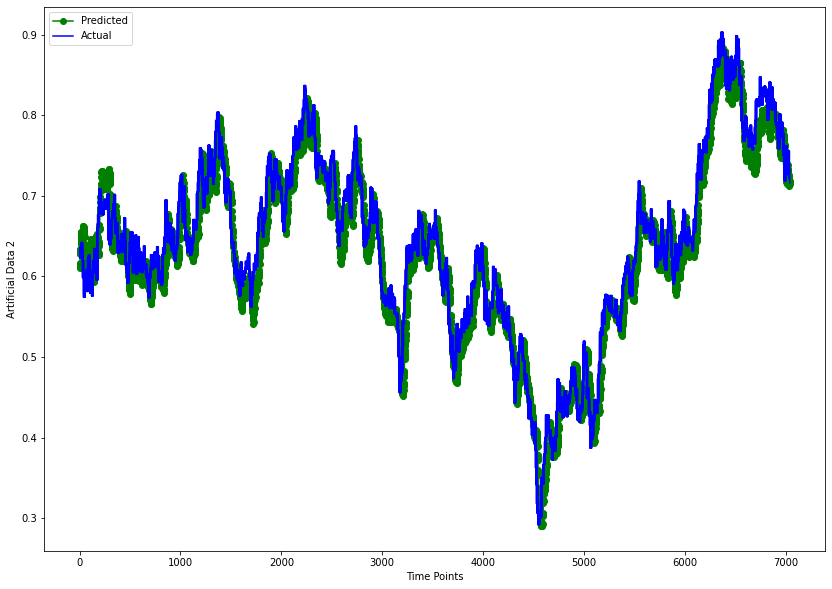

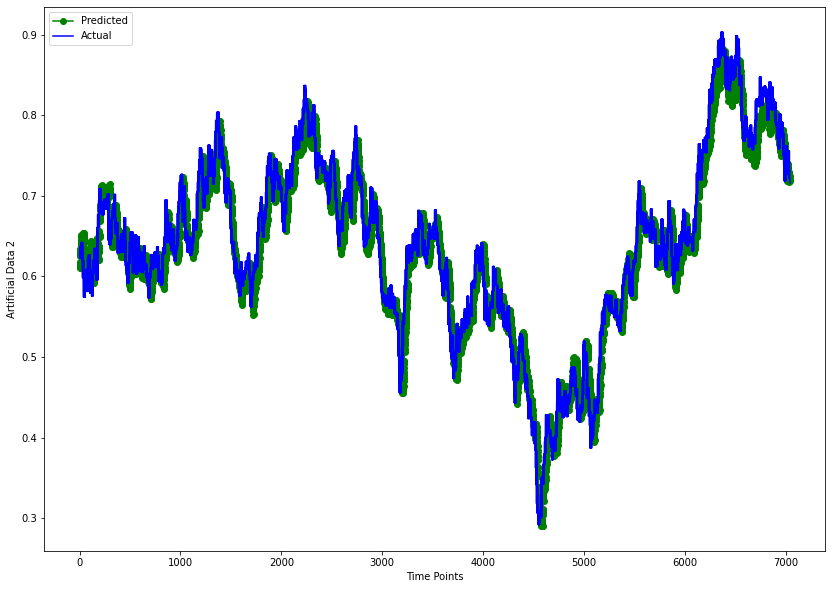

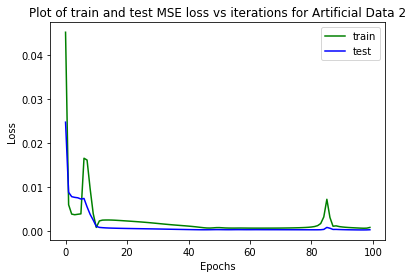

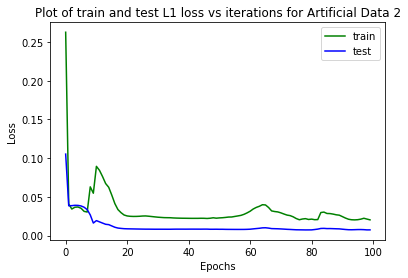

In [ ]:
run_on_dataset(artificial2_df, 1, "Artificial Data 2", learning_rate)

# Microsoft Stock

Iteration 0
********************
The MSE loss for train is: 0.3484621047973633
The MSE loss for test is: 0.3484621047973633
Iteration 1
********************
The MSE loss for train is: 0.2926773726940155
The MSE loss for test is: 0.2926773726940155
Iteration 2
********************
The MSE loss for train is: 0.23732154071331024
The MSE loss for test is: 0.23732154071331024
Iteration 3
********************
The MSE loss for train is: 0.18071073293685913
The MSE loss for test is: 0.18071073293685913
Iteration 4
********************
The MSE loss for train is: 0.1286080926656723
The MSE loss for test is: 0.1286080926656723
Iteration 5
********************
The MSE loss for train is: 0.09425517171621323
The MSE loss for test is: 0.09425517171621323
Iteration 6
********************
The MSE loss for train is: 0.08074814081192017
The MSE loss for test is: 0.08074814081192017
Iteration 7
********************
The MSE loss for train is: 0.07820738106966019
The MSE loss for test is: 0.0782073810696601

([0.3484621047973633,
  0.2926773726940155,
  0.23732154071331024,
  0.18071073293685913,
  0.1286080926656723,
  0.09425517171621323,
  0.08074814081192017,
  0.07820738106966019,
  0.07839776575565338,
  0.07870235294103622,
  0.07878594845533371,
  0.07870513200759888,
  0.07854040712118149,
  0.07834338396787643,
  0.07813533395528793,
  0.07791376113891602,
  0.07766980677843094,
  0.07739537954330444,
  0.07707905024290085,
  0.07670900970697403,
  0.07626765221357346,
  0.07572976499795914,
  0.07506943494081497,
  0.07424481213092804,
  0.0732007548213005,
  0.07186195254325867,
  0.0701260194182396,
  0.0678519532084465,
  0.06487658619880676,
  0.06106281280517578,
  0.056382160633802414,
  0.051014214754104614,
  0.04526756703853607,
  0.03945388272404671,
  0.033832620829343796,
  0.028698740527033806,
  0.024372877553105354,
  0.02100302092730999,
  0.018522346392273903,
  0.016769075766205788,
  0.015580934472382069,
  0.014816969633102417,
  0.014351156540215015,
  0.014

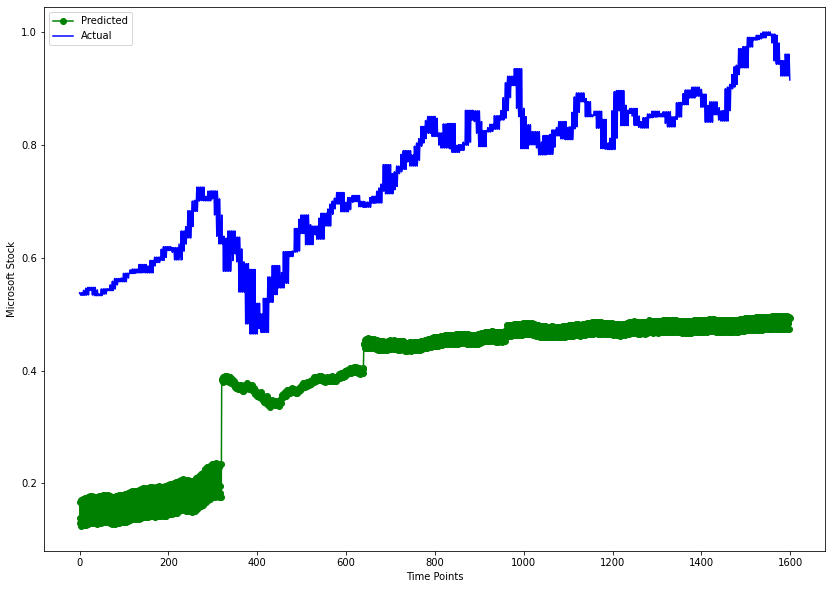

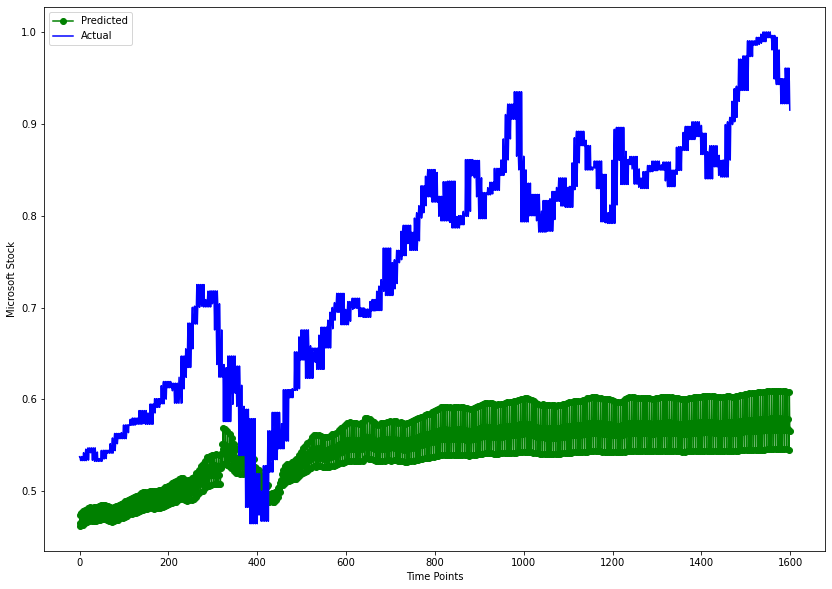

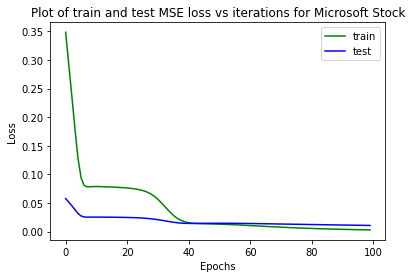

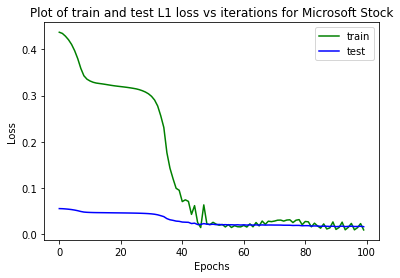

In [ ]:
run_on_dataset(microsoft_df, 4, "Microsoft Stock", learning_rate)

# Crude Oil

Iteration 0
********************
The MSE loss for train is: 0.23180346190929413
The MSE loss for test is: 0.23180346190929413
Iteration 1
********************
The MSE loss for train is: 0.20842604339122772
The MSE loss for test is: 0.20842604339122772
Iteration 2
********************
The MSE loss for train is: 0.18723617494106293
The MSE loss for test is: 0.18723617494106293
Iteration 3
********************
The MSE loss for train is: 0.1643027514219284
The MSE loss for test is: 0.1643027514219284
Iteration 4
********************
The MSE loss for train is: 0.13672922551631927
The MSE loss for test is: 0.13672922551631927
Iteration 5
********************
The MSE loss for train is: 0.1030498743057251
The MSE loss for test is: 0.1030498743057251
Iteration 6
********************
The MSE loss for train is: 0.06820245832204819
The MSE loss for test is: 0.06820245832204819
Iteration 7
********************
The MSE loss for train is: 0.04605700820684433
The MSE loss for test is: 0.04605700820684

([0.23180346190929413,
  0.20842604339122772,
  0.18723617494106293,
  0.1643027514219284,
  0.13672922551631927,
  0.1030498743057251,
  0.06820245832204819,
  0.04605700820684433,
  0.03758225589990616,
  0.03432094678282738,
  0.033811625093221664,
  0.03460630774497986,
  0.035616435110569,
  0.03639822080731392,
  0.03689737245440483,
  0.03718502074480057,
  0.037341199815273285,
  0.03742239996790886,
  0.037462688982486725,
  0.0374804325401783,
  0.037483442574739456,
  0.037474434822797775,
  0.037451546639204025,
  0.03741197660565376,
  0.03735210373997688,
  0.037276457995176315,
  0.037198055535554886,
  0.03714415058493614,
  0.037128400057554245,
  0.03712333366274834,
  0.03708527237176895,
  0.03700638934969902,
  0.03697250038385391,
  0.037269171327352524,
  0.03910453990101814,
  0.04472051188349724,
  0.042018722742795944,
  0.05522418022155762,
  0.01618170738220215,
  0.06230514124035835,
  0.020482148975133896,
  0.025823384523391724,
  0.015052606351673603,
  

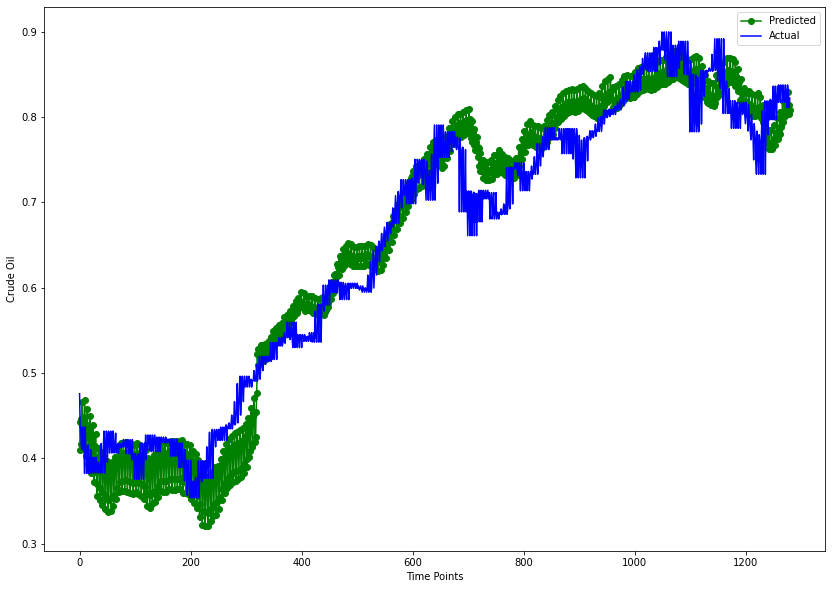

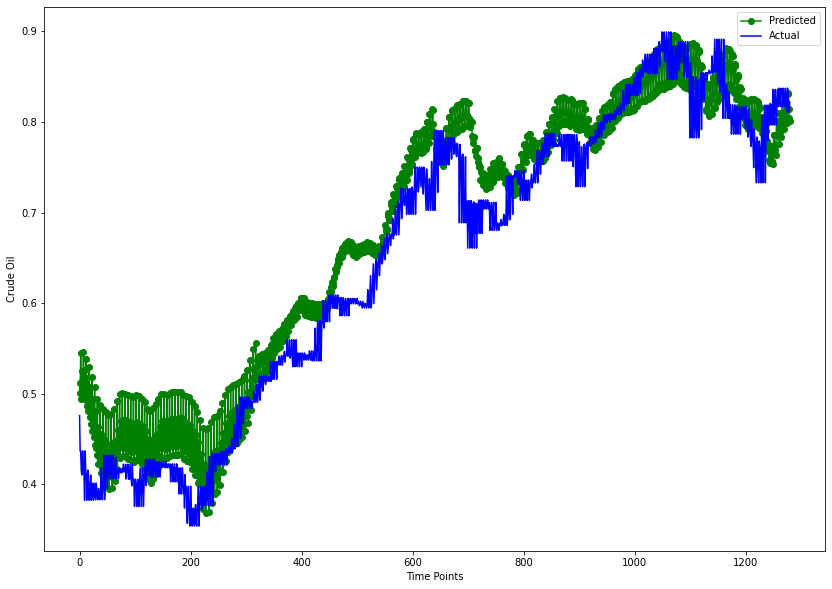

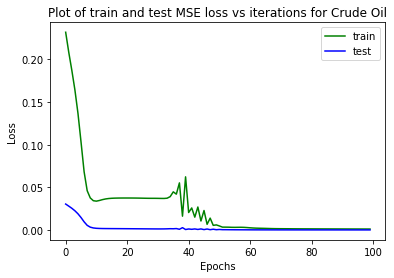

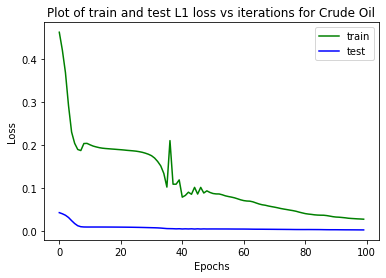

In [ ]:
oil_df = oil_df[oil_df.DCOILBRENTEU != "."]
run_on_dataset(oil_df, 1, "Crude Oil", learning_rate)

# Bitcoin

Iteration 0
********************
The MSE loss for train is: 0.03805052489042282
The MSE loss for test is: 0.03805052489042282
Iteration 1
********************
The MSE loss for train is: 0.015312815085053444
The MSE loss for test is: 0.015312815085053444
Iteration 2
********************
The MSE loss for train is: 0.008404381573200226
The MSE loss for test is: 0.008404381573200226
Iteration 3
********************
The MSE loss for train is: 0.008917242288589478
The MSE loss for test is: 0.008917242288589478
Iteration 4
********************
The MSE loss for train is: 0.009234408847987652
The MSE loss for test is: 0.009234408847987652
Iteration 5
********************
The MSE loss for train is: 0.009301274083554745
The MSE loss for test is: 0.009301274083554745
Iteration 6
********************
The MSE loss for train is: 0.009319223463535309
The MSE loss for test is: 0.009319223463535309
Iteration 7
********************
The MSE loss for train is: 0.009324690327048302
The MSE loss for test is:

([0.03805052489042282,
  0.015312815085053444,
  0.008404381573200226,
  0.008917242288589478,
  0.009234408847987652,
  0.009301274083554745,
  0.009319223463535309,
  0.009324690327048302,
  0.00932757742702961,
  0.009330367669463158,
  0.009332808665931225,
  0.009335215203464031,
  0.009337899275124073,
  0.009340442717075348,
  0.009342983365058899,
  0.009345456957817078,
  0.009347490034997463,
  0.009350075386464596,
  0.009351915679872036,
  0.009353927336633205,
  0.0093558793887496,
  0.009357383474707603,
  0.009358814917504787,
  0.009359936229884624,
  0.009360835887491703,
  0.009361534379422665,
  0.009361990727484226,
  0.009362049400806427,
  0.009361885488033295,
  0.009361149743199348,
  0.0093602379783988,
  0.009358805604279041,
  0.009356720373034477,
  0.0093540595844388,
  0.009350697509944439,
  0.009346386417746544,
  0.009340946562588215,
  0.009334084577858448,
  0.009325253777205944,
  0.009314054623246193,
  0.00929915253072977,
  0.009279187768697739,
 

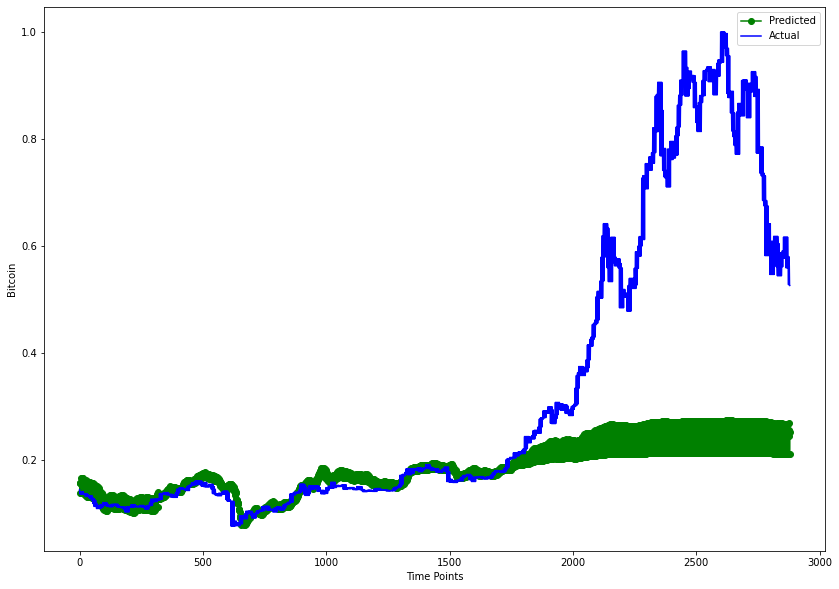

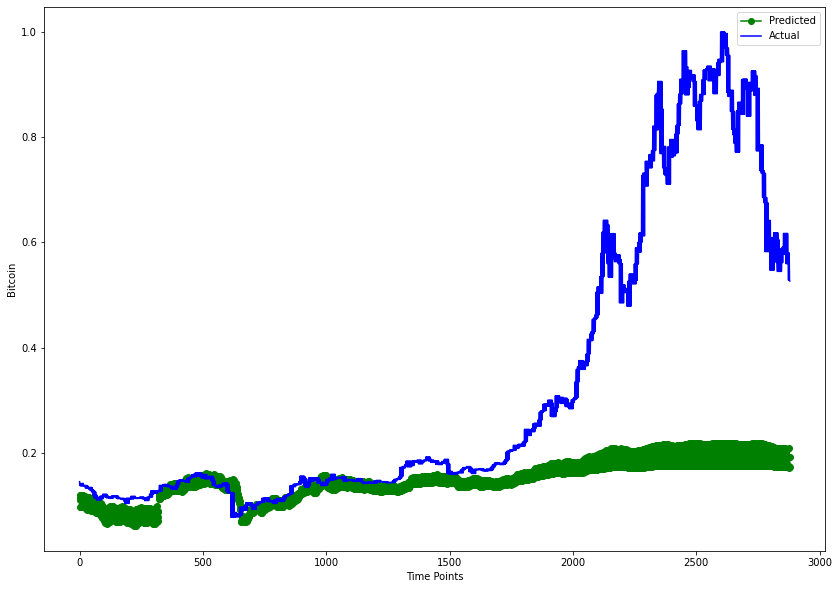

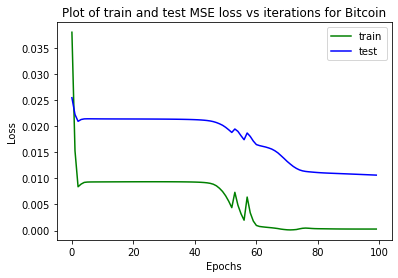

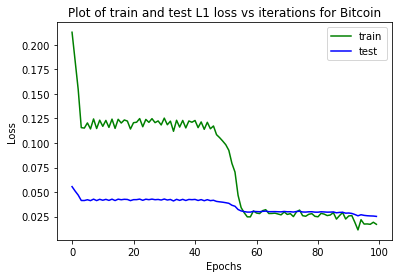

In [ ]:
run_on_dataset(coin_df, 7, "Bitcoin", learning_rate)

# S&P 500

Iteration 0
********************
The MSE loss for train is: 0.012264052405953407
The MSE loss for test is: 0.012264052405953407
Iteration 1
********************
The MSE loss for train is: 0.004059118218719959
The MSE loss for test is: 0.004059118218719959
Iteration 2
********************
The MSE loss for train is: 0.0026300360914319754
The MSE loss for test is: 0.0026300360914319754
Iteration 3
********************
The MSE loss for train is: 0.005449038930237293
The MSE loss for test is: 0.005449038930237293
Iteration 4
********************
The MSE loss for train is: 0.0052156164310872555
The MSE loss for test is: 0.0052156164310872555
Iteration 5
********************
The MSE loss for train is: 0.00479570496827364
The MSE loss for test is: 0.00479570496827364
Iteration 6
********************
The MSE loss for train is: 0.004869046155363321
The MSE loss for test is: 0.004869046155363321
Iteration 7
********************
The MSE loss for train is: 0.004899810999631882
The MSE loss for test

([0.012264052405953407,
  0.004059118218719959,
  0.0026300360914319754,
  0.005449038930237293,
  0.0052156164310872555,
  0.00479570496827364,
  0.004869046155363321,
  0.004899810999631882,
  0.0048979842104017735,
  0.00490582874044776,
  0.004912268836051226,
  0.0049171666614711285,
  0.004921968560665846,
  0.004926331341266632,
  0.004930309485644102,
  0.00493399566039443,
  0.004937378223985434,
  0.0049403659068048,
  0.004943280015140772,
  0.004945933818817139,
  0.004948318004608154,
  0.0049505517818033695,
  0.004952617920935154,
  0.004954601172357798,
  0.004956338554620743,
  0.004958040546625853,
  0.004959494806826115,
  0.004960925318300724,
  0.004962212406098843,
  0.004963356535881758,
  0.0049644894897937775,
  0.004965494852513075,
  0.004966482054442167,
  0.004967277403920889,
  0.004968126770108938,
  0.004968819208443165,
  0.004969476256519556,
  0.004970122594386339,
  0.004970618523657322,
  0.004971144255250692,
  0.004971546586602926,
  0.00497193960

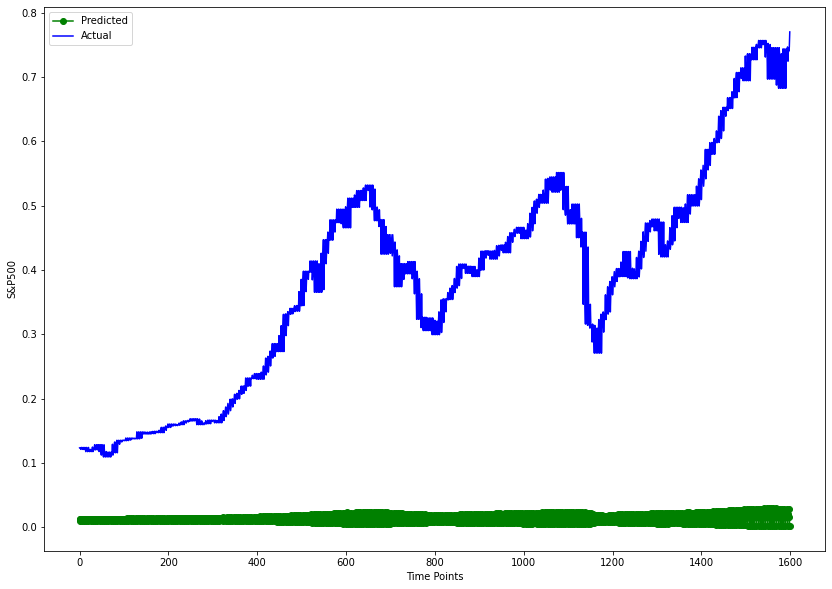

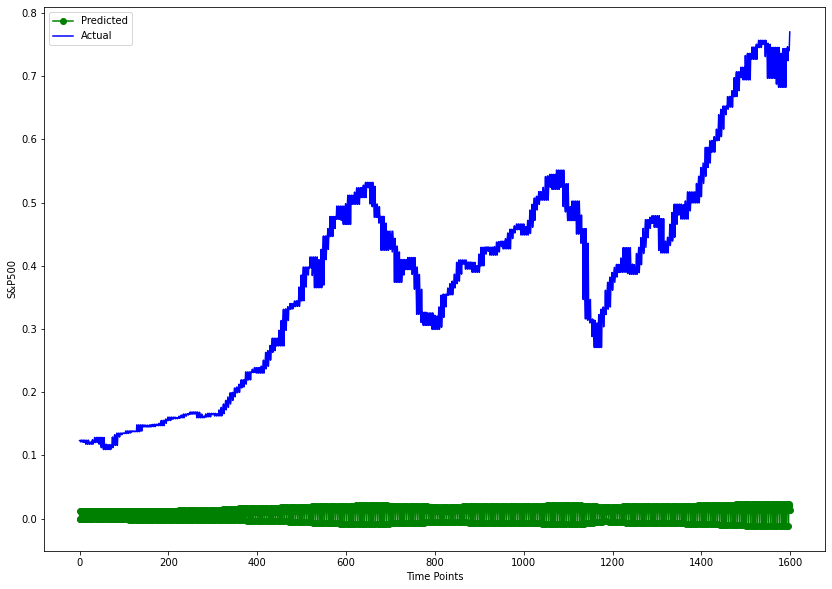

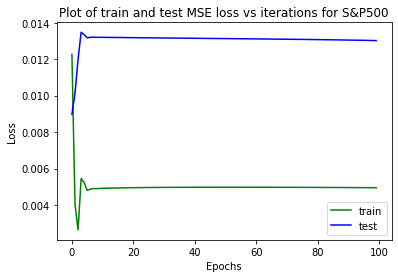

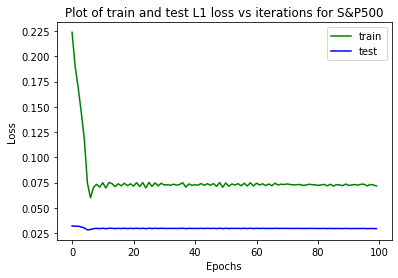

In [ ]:
run_on_dataset(sp500_df, 1, "S&P500", learning_rate)